In [70]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Ellipse
import statistics as stat
from scipy.stats import vonmises, linregress
import math
#import pandas as pd
import pycircular as pyc
from functions_file import *
from scipy import interpolate
from statsmodels.tsa.stattools import acf
from scipy.optimize import curve_fit
import scipy.special as sp
from functools import partial
from matplotlib.animation import FuncAnimation
from scipy.optimize import minimize



In [71]:
#variables time
multiplying_factor_time = 10
T = 500*multiplying_factor_time #milliseconds, total time
T0 = 0 #ms
dt_position = 1 #ms
dt_spikewindow = 1 #ms

N_steps = int(np.floor(T/dt_position))
T_rounded = int(N_steps*dt_position)


#the number of time points is different from the number of steps. In the array (0,1,2) there are 2 steps and 3 points
 #if we wanna include in the count both the edges, because our starting point number is 0 (if it was 1 that is not necessary)
N_time_points = N_steps+1


#the function linspace creates a linearly spaced points INCLUDING both 0 and T_rounded, so the number of data points is N_steps + 1
T_vec0 = np.linspace(0, T_rounded, N_time_points)  


#reshaping the time vector 
T_vec = T_vec0.reshape(T_vec0.size, 1)

#print('T_vec: ', T_vec)
print('shape of the time vector:', T_vec.shape)



shape of the time vector: (5001, 1)


In [72]:
#variable initialization
sigma = 0.05  #[1/ms] #this would be in order to have a correlation time of about 20 ms, so the decoding time about 10 ms would be valid
mu_X = 0 #0 #DRIFT #note: the velocity is directional +/-
#theta_X = 10 #threshold

X0 = mu_X #initial velocity equal to the mean velocity to avoid initial setting behaviour
X = np.zeros((N_time_points, 1))
dX = np.zeros((N_time_points, 1))
X[0] = X0

#
#seed = np.random.randint(0, 2**32)
#np.random.seed(seed)

seed = 72


#simulation of white noise

diff_const = 2*np.pi*(10**(-3))*np.sqrt(2)*np.sqrt(sigma) #100*(10**(-9/2))/0.00063 #diffusion constant #
mean_wn, std_wn = 0, 1


#np.random.seed(seed_wn)
wnoise_value = diff_const*np.sqrt(dt_position)*np.random.normal(mean_wn, std_wn, size = N_time_points)



#Ornstein-Uhlenbeck process 
#((note that this t is not really the time but more the index indicator))

for t in range(T0, N_time_points-1):   #the minus 1 is necessary because an array (21,1) has row indeces that goes from 0 to 20

    dX[t] = sigma*(mu_X - X[t])*dt_position + wnoise_value[t]

    X[t + 1] = X[t] + dX[t]


print(np.mean(X))

#second time integration to derive HD
Y0 = 0     #head starting direction
Y = np.zeros((N_time_points, 1))
Y[0] = Y0       

for t in range(T0, N_time_points-1):
    Y[t+1] = Y[t] + X[t]*dt_position


#define the HD as a circular variable
theta_HD = Y % (2*np.pi) - np.pi #theta goes from -pi to pi
print(theta_HD.shape)




-0.0003327533203677242
(5001, 1)


3.141592653589793
9.42289699055003


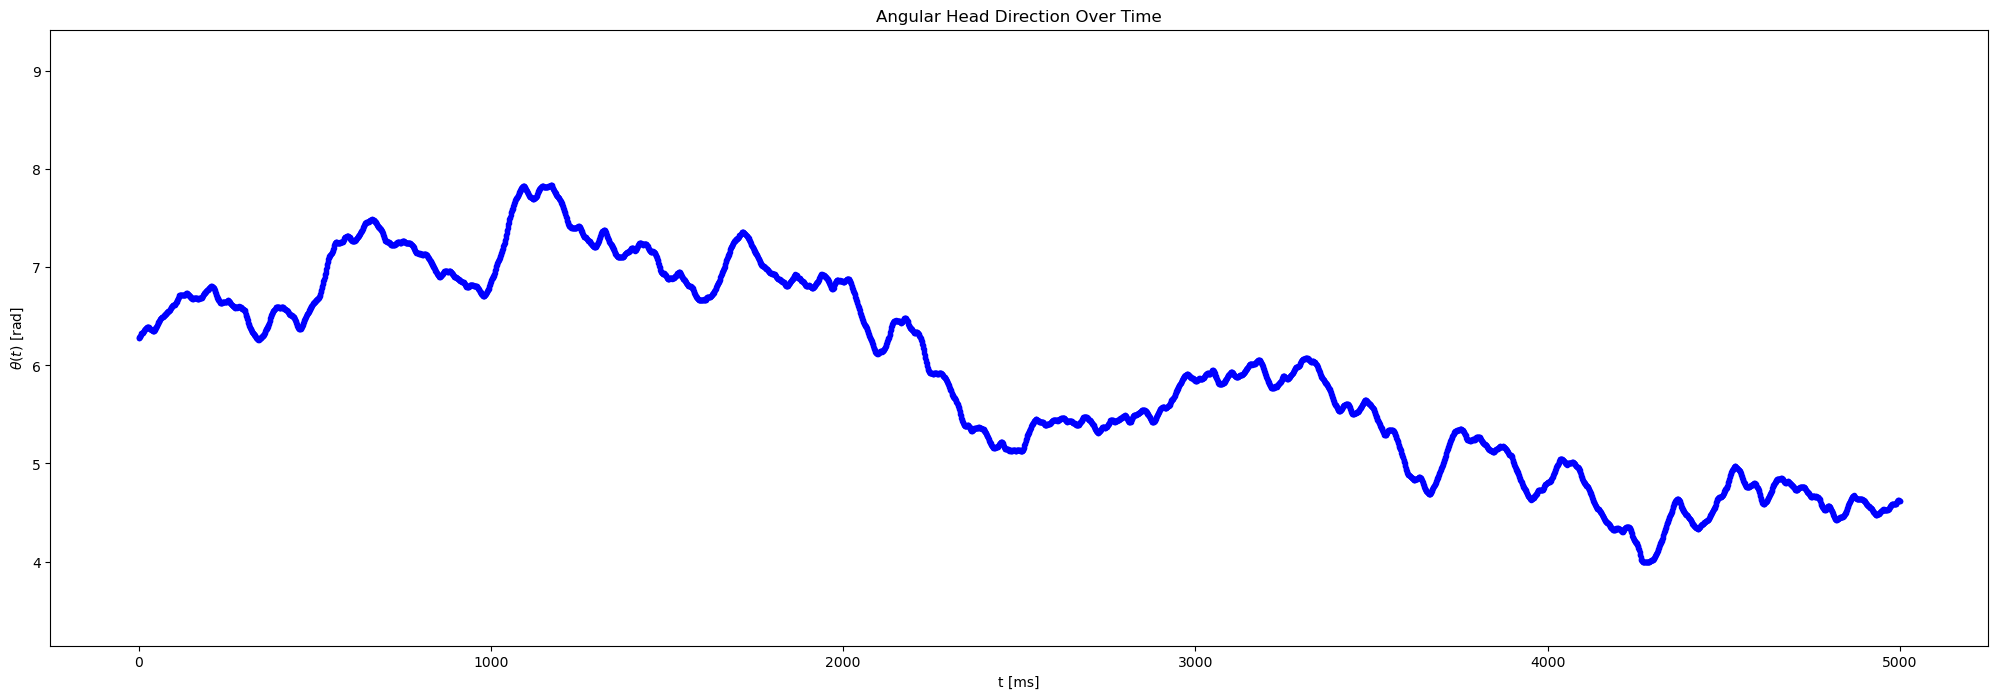

Var_X_exp:  3.8273368397276177e-05
Var_X_theor:  3.947841760435743e-05


In [73]:
#finding the best limits for the graphs of the trajecory

min_thetaHD = np.min(theta_HD)
max_thetaHD = np.max(theta_HD)

bottom_limit = min_thetaHD + 2*np.pi 
up_limit= max_thetaHD + 2*np.pi 

print(bottom_limit)
print(up_limit)


fig, ax = plt.subplots(figsize=(25,8))  # Adjust the figure size (width, height in inches)

# Plot data with the same color
ax.plot(T_vec, theta_HD + np.pi, '.', color='blue', label=r'$\theta(t)$')
ax.plot(T_vec, theta_HD + 3* np.pi, '.', color='blue', label=r'$\theta(t) + 2\pi$')
ax.set_ylim([bottom_limit, up_limit])
# Add labels, title, and legend
ax.set_xlabel("t [ms]")
ax.set_ylabel(r"$\theta(t)$ [rad]")
ax.set_title('Angular Head Direction Over Time')
#ax.legend()

# Show the plot
plt.show()

velocity_vector = X
#Variance of the OU process on X from the data

Var_X_exp = np.sum((X-np.mean(X))**2)/N_time_points
#note on denominator:
#   -sample variance -> divide for N_time_points -1
#   -population variance -> divide for N_time_points
#a sample is so e data from the population, which is consistent of way more datapoints. To avoid an underestimation of the population 
# variance, we divide for N_time_points -1 in the case of a sample, to get closer to the real variance. 

Var_X_theor = (diff_const**2)/(2*sigma)

print('Var_X_exp: ',Var_X_exp)
print('Var_X_theor: ', Var_X_theor)

In [74]:
N_neurons = 50 #numebr of neurons

# random neurons' preferred directions
seed = 54
np.random.seed(seed)
neuro_pref_dir_vector = np.random.uniform(-np.pi, np.pi, N_neurons)
neuro_pref_dir_vector = np.sort(neuro_pref_dir_vector)


print('first, middle, last pref dir:', 
      [neuro_pref_dir_vector[0], neuro_pref_dir_vector[len(neuro_pref_dir_vector) // 2 ] ,neuro_pref_dir_vector[-1]])

#print(len(neuro_pref_dir_vector) // 2 )

first, middle, last pref dir: [-3.087523003966655, -0.24657134118247853, 3.1224758297374846]


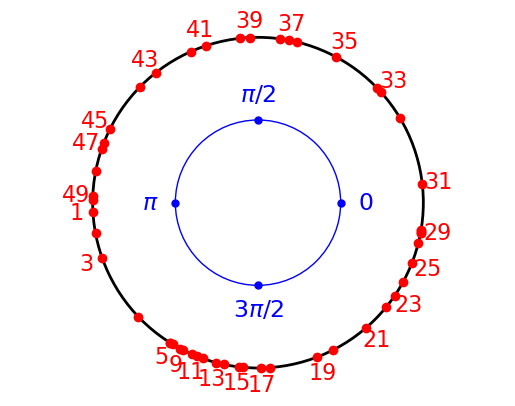

In [75]:
angles = neuro_pref_dir_vector  # Adjust angles

# Convert to Cartesian coordinates for plotting
x = np.cos(angles)
y = np.sin(angles)

# Circle parameters
radius = 1
radii_step = 2*np.pi / (50+1) # Step size in radians

# Generate radii angles
radii_ang = np.arange(-np.pi,  np.pi, radii_step)

# Compute points on the circle for the radii
radii_x = radius * np.cos(radii_ang)
radii_y = radius * np.sin(radii_ang)

# Create the existing figure
fig, ax = plt.subplots(figsize=(6.4, 4.8))
circle = plt.Circle((0, 0), 1, color='black', fill=False, linewidth=2)
ax.add_artist(circle)

# Plot all points and add labels (showing only odd numbers with increased font size)
for i, (xi, yi) in enumerate(zip(x, y), start=1):
    ax.plot(xi, yi, 'ro')  # Plot all the points as red dots
    # Skip number 27
    if i == 27:
        continue
    if i == 7:
        continue
    # Increase the font size by 40% for odd numbers
    if i % 2 != 0:  # Check if the index is odd
        ax.text(xi * 1.1, yi * 1.1, str(i), color='red', fontsize=16, ha='center', va='center')
    

# Add a smaller concentric circle
small_radius = 0.5  # Smaller radius for the inner circle
small_circle = plt.Circle((0, 0), small_radius, color='blue', fill=False, linewidth=1)
ax.add_artist(small_circle)

angle_labels = [0, np.pi / 2, np.pi, 3 * np.pi / 2]
angle_strings = [
    r'$0$', 
    r'$\pi/2$', 
    r'$\pi$', 
    r'$3\pi/2$'
]

for angle, label in zip(angle_labels, angle_strings):
    # Calculate the position of the angle on the smaller circle
    x_pos = small_radius * np.cos(angle)
    y_pos = small_radius * np.sin(angle)
    
    ax.plot(x_pos, y_pos, 'bo', markersize=5)  # Smaller blue dot
    
    # Add labels with a larger font size and adjusted distance
    ax.text(x_pos * 1.3, y_pos * 1.3, label, color='blue', fontsize=17, ha='center', va='center')

# Adjust plot limits and appearance
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_aspect('equal', adjustable='datalim')
ax.axis('off')  # Hide axes for a cleaner look

plt.show()

In [76]:
angles_on_a_circle, step_angle = np.linspace(-np.pi, np.pi, 500, retstep = True)

distance_matrix = np.sqrt((np.sin(angles_on_a_circle[:, None]) - np.sin(neuro_pref_dir_vector[None, :]))**2 + (np.cos(angles_on_a_circle[:, None]) - np.cos(neuro_pref_dir_vector[None, :]))**2)

mean_distance_vector = np.mean(distance_matrix, axis = 1)

mean_adjacent_neurons = []

# Iterate through each row of the distance matrix
for row in distance_matrix:
    # Find the two smallest numbers in the row
    smallest_two = np.partition(row, 2)[:2]  # Get the two smallest numbers
    mean_value = np.mean(smallest_two)  # Calculate the mean of the two smallest numbers
    mean_adjacent_neurons.append(mean_value)  # Append the result to the list

# Convert the list to a numpy array if needed
mean_adjacent_neurons = np.array(mean_adjacent_neurons)

sum_curves = np.zeros(len(angles_on_a_circle))
h = 1
a_neuro_pos, b_neuro_pos, k_neuro_pos = 0, 1, 5

for j, angle in enumerate(angles_on_a_circle):
    sum_exp = 0  # Initialize sum for this particular angle
    for i in range(N_neurons):
        # Calculate the difference between the current angle and the neuron's preferred direction
        diff = -np.pi + ((angle- neuro_pref_dir_vector[i]+ np.pi) % (2*np.pi))
        
        # Ensure periodicity by adjusting the difference to stay within -pi to pi
        #diff = (diff + np.pi) % (2 * np.pi) - np.pi
        
        # Compute the Gaussian value for this difference
        #gaussian_value = np.exp(- (diff**2) / (2 * h**2))
        vonmises_value = VonMisesFunction(a_neuro_pos, b_neuro_pos, k_neuro_pos, angle, neuro_pref_dir_vector[i])
        # Accumulate the sum of Gaussian values
        #sum_exp += gaussian_value
        sum_exp += vonmises_value
    # Final sum for this angle
    sum_curves[j] = sum_exp #(1 / (N_neurons * h)) * sum_exp

# Print the resulting sum_gaussian
#print(sum_gaussian)

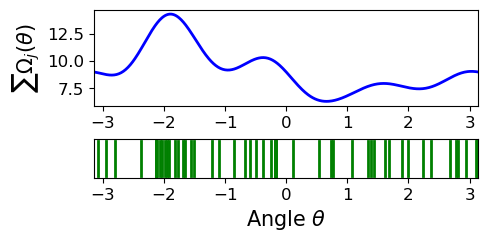

9.00324670546473


In [77]:
fig = plt.figure(figsize=(6.4, 4.8))


# Create the top plot for `density_neurons` (this is where you will plot the distribution)
ax_top = fig.add_axes([0.1, 0.2, 0.6, 0.2])

# For now, I'll create a mock density distribution (just for illustration)
# You will replace this with your actual 'density_neurons' data
x = angles_on_a_circle 
y = sum_curves #1/mean_distance_vector # sum_curves

ax_top.plot(x, y, color='blue', linewidth=2)
#ax_top.set_title("Some 'density' quantity")
ax_top.set_ylabel(r"$\sum \Omega_j(\theta)$", fontsize = 15)
ax_top.set_xlim([-np.pi, np.pi])
# Set font size for tick labels
ax_top.tick_params(axis='x', labelsize=12)  # x-axis tick labels
ax_top.tick_params(axis='y', labelsize=12)  # y-axis tick labels

#ax_top.set_ylim(0, 1)

# Create the bottom plot for neuron preferred directions (this will be under the top plot)
ax_bottom = fig.add_axes([0.1, 0.05, 0.6, 0.08]) 


# Shift for alignment
y_positions_1 = neuro_pref_dir_vector #+ np.pi
y_positions_2 = neuro_pref_dir_vector + 2 * np.pi

# Plot the first set (neuro_pref_dir_vector + np.pi)
for y in y_positions_1:
    ax_bottom.plot( [y, y], [0,1], color='green', linewidth=2)  # Line of length 1

# Plot the second set (neuro_pref_dir_vector + 3*np.pi)
for y in y_positions_2:
    ax_bottom.plot([y, y], [0,1], color='green', linewidth=2)  # Line of length 1

# Set limits and appearance of the bottom plot
ax_bottom.set_xlim(ax_top.get_xlim())  # Align y-limits with the density plot
ax_bottom.set_xlabel(r'Angle $\theta$', fontsize = 15)
ax_bottom.set_yticks([])  # Hide x-axis ticks
ax_bottom.tick_params(axis='x', left=False, right=True, labelleft=False, labelright=True)
# Set font size for tick labels
ax_bottom.tick_params(axis='x', labelsize=12)  # x-axis tick labels
ax_bottom.tick_params(axis='y', labelsize=12)  # y-axis tick labels

plt.show()

print(sum_curves[j])

modifying the tuning curves to 'correct' for the uneveness

Tecnique : minimizing the variation

Case 1 : varying b and k

In [78]:
def sum_curves_bk(angle, b, k):
    a = 0
    # Vectorized computation of VonMisesFunction for all angles and neurons
    vonmises_values = np.array([
        [VonMisesFunction(a, b[i], k[i], angle, neuro_pref_dir_vector[i]) 
         for i in range(N_neurons)]
    ])
    # Sum over neurons
    sum_curves = np.sum(vonmises_values) 
    return sum_curves


def flatness_objective_bk(params):
    # Split the parameter array into b and k
    b = params[:len(neuro_pref_dir_vector)]  # First part is for b
    k = params[len(neuro_pref_dir_vector):]  # Second part is for k
    
    variations = []
    for angle in angles_on_a_circle:
        variations.append(sum_curves_bk(angle, b, k))  # Compute sum_curves for each angle
    
    return np.var(variations) / np.mean(variations)**2

# Initial guess for b and k (same length as neuro_pref_dir_vector)
initial_b = np.ones_like(neuro_pref_dir_vector)  # Initial guess for b
initial_k = np.ones_like(neuro_pref_dir_vector)  # Initial guess for k (array of 1s)

# Combine b and k into one array for optimization
initial_guess = np.concatenate([initial_b, initial_k])

# Bounds for b and k
bounds_b = [(0, 30)] * len(neuro_pref_dir_vector)  # Bounds for each element of b
bounds_k = [(0, 30)] * len(neuro_pref_dir_vector)  # Bounds for each element of k
bounds = bounds_b + bounds_k  # Combine bounds for both b and k

# Minimize the flatness objective
result_bk = minimize(flatness_objective_bk, initial_guess, bounds=bounds)

# Get the optimized values of b and k
b_optimal = result_bk.x[:len(neuro_pref_dir_vector)]  # Optimal b values
k_optimal = result_bk.x[len(neuro_pref_dir_vector):]  # Optimal k values

print(f"Optimal b values: {b_optimal}")
print(f"Optimal k values: {k_optimal}")

Optimal b values: [0.96991585 0.93809695 0.89917428 0.79992208 0.75345859 0.75300783
 0.75047893 0.74316869 0.74036102 0.73324322 0.7300945  0.72657251
 0.72017087 0.71774218 0.7154223  0.7152983  0.71753129 0.72000788
 0.75293141 0.77261786 0.82883087 0.88005675 0.90610815 0.93767946
 0.98102793 1.02438987 1.04612259 1.0464727  1.05039974 1.05175105
 1.14196333 1.24046206 1.26531521 1.26784353 1.27387014 1.25779053
 1.25328383 1.24786069 1.22738999 1.21974234 1.19159136 1.17884464
 1.14408398 1.12598172 1.07576784 1.05845477 1.05223427 1.02501944
 0.99208288 0.98682589]
Optimal k values: [1.02456871 1.01616357 1.0023749  0.95591528 0.93012037 0.92986265
 0.92836015 0.92396665 0.92223033 0.9177212  0.9156535  0.91324493
 0.90843963 0.90628206 0.90321779 0.90262362 0.90103932 0.90098262
 0.90852297 0.91454249 0.93358069 0.95246898 0.9625406  0.97514966
 0.99314121 1.01184195 1.02144611 1.02159551 1.02335275 1.02394357
 1.06435117 1.09966182 1.0982854  1.09688746 1.06866255 1.03488147
 1

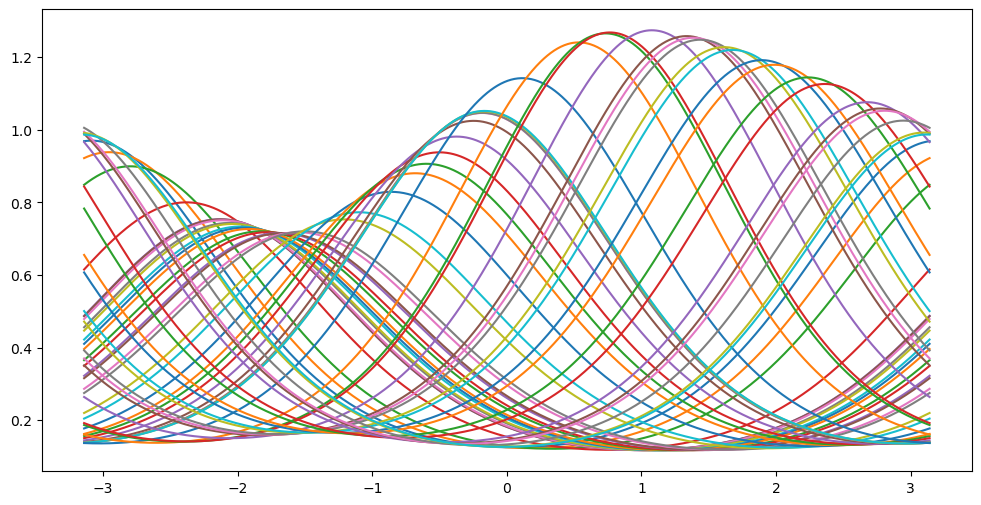

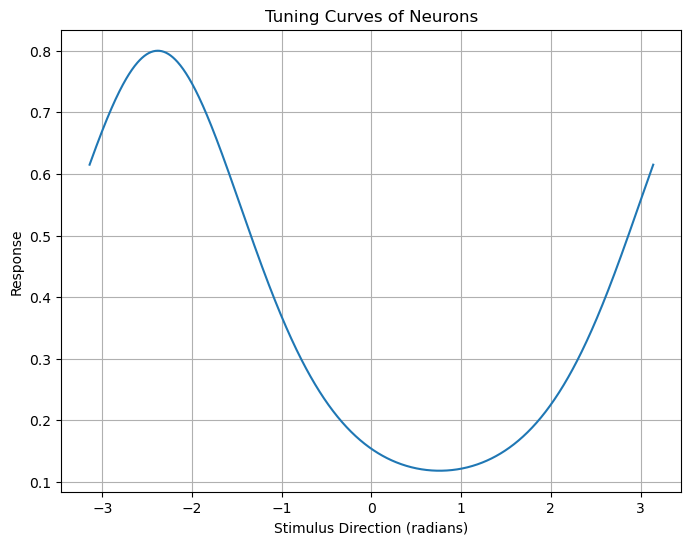

In [79]:
N_points_function = 1001
x_points = np.linspace(-np.pi, np.pi, N_points_function)

tuning_curves = np.zeros((N_neurons, N_points_function)) #initialization

for i in range(0, N_neurons):

    pref_HD_eachneuron = neuro_pref_dir_vector[i]
    pref_dir_vector_eachneuro= pref_HD_eachneuron*np.ones_like(x_points)
    tuning_curves[i, :] = VonMisesFunction(0,b_optimal[i],k_optimal[i],x_points,pref_HD_eachneuron)

# Plot all tuning curves
plt.figure(figsize=(12, 6))
for i in range(N_neurons):
    plt.plot(x_points, tuning_curves[i, :], label=f'Neuron {i+1} (Pref Dir: {neuro_pref_dir_vector[i]:.2f})')

plt.figure(figsize=(8, 6))
plt.plot(x_points, tuning_curves[3], label=f'Neuron {3} (Pref Dir: {neuro_pref_dir_vector[i]:.2f})')

# Adding labels and title
plt.xlabel('Stimulus Direction (radians)')
plt.ylabel('Response')
plt.title('Tuning Curves of Neurons')
#plt.legend()
plt.grid(True)

# Display the plot
plt.show()



In [80]:
angles_on_a_circle_bk = np.linspace(-np.pi, np.pi, 500)
sum_curves_bk = np.zeros(len(angles_on_a_circle_bk))


for j, angle in enumerate(angles_on_a_circle_bk):
    sum_eachx_bk = 0  # Initialize sum for this particular angle
    for i in range(N_neurons):
        
        # Ensure periodicity by adjusting the difference to stay within -pi to pi
        #diff = (diff + np.pi) % (2 * np.pi) - np.pi
        
        # Compute the Gaussian value for this difference
        #gaussian_value = np.exp(- (diff**2) / (2 * h**2))
        vonmises_value = VonMisesFunction(0, b_optimal[i], k_optimal[i], angle, neuro_pref_dir_vector[i])
        # Accumulate the sum of Gaussian values
        #sum_exp += gaussian_value
        sum_eachx_bk += vonmises_value
    # Final sum for this angle
    sum_curves_bk[j] = sum_eachx_bk 

print('variance of sum of tuning curves', np.var(sum_curves_bk))

variance of sum of tuning curves 0.0017084924095198636


/var/folders/f7/d5fmkkj95vz3mq9xggxz6j900000gn/T/ipykernel_2150/3806000126.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


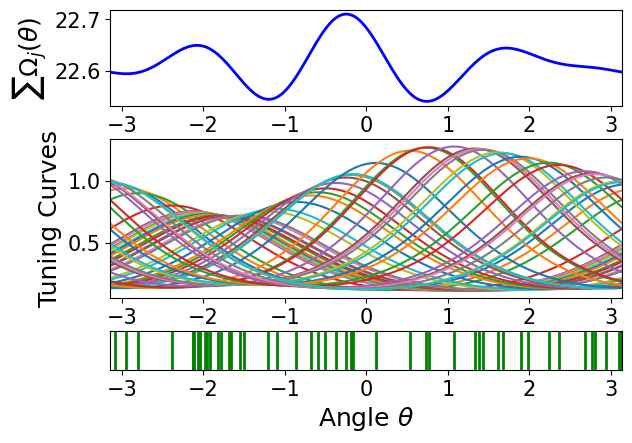

In [81]:
# Create the main figure with larger height to accommodate three plots
fig = plt.figure(figsize=(6.4, 4.8))

# Create the top plot for `density_neurons`
ax_top = fig.add_axes([0.1, 0.6, 0.8, 0.2])  # top plot with larger height  #[left, bottom, width, height]

# For now, I'll create a mock density distribution (just for illustration)
# You will replace this with your actual 'density_neurons' data
x = angles_on_a_circle
y = sum_curves_bk # Replace with the correct sum_curves data

ax_top.plot(x, y, color='blue', linewidth=2)

ax_top.set_ylabel(r"$\sum \Omega_j(\theta)$", fontsize=18)
ax_top.set_xlim([-np.pi, np.pi])
ax_top.tick_params(axis='x', labelsize=15)  
ax_top.tick_params(axis='y', labelsize=15)

# Create the middle plot for tuning curves
ax_middle = fig.add_axes([0.1, 0.2, 0.8, 0.33])  # middle plot

# Plot the tuning curves for neurons
for i in range(N_neurons):
    ax_middle.plot(x_points, tuning_curves[i, :], label=f'Neuron {i+1} (Pref Dir: {neuro_pref_dir_vector[i]:.2f})')


ax_middle.set_ylabel('Tuning Curves', fontsize=18)
ax_middle.set_xlim([-np.pi, np.pi])
ax_middle.tick_params(axis='x', labelsize=15)  # x-axis tick labels
ax_middle.tick_params(axis='y', labelsize=15)
#ax_middle.grid(True)

# Create the bottom plot for neuron preferred directions
ax_bottom = fig.add_axes([0.1, 0.05, 0.8, 0.08])  # bottom plot with smaller height

# Shift for alignment
y_positions_1 = neuro_pref_dir_vector
y_positions_2 = neuro_pref_dir_vector + 2 * np.pi

# Plot the first set (neuro_pref_dir_vector + np.pi)
for y in y_positions_1:
    ax_bottom.plot([y, y], [0, 1], color='green', linewidth=2)  # Line of length 1

# Plot the second set (neuro_pref_dir_vector + 3*np.pi)
for y in y_positions_2:
    ax_bottom.plot([y, y], [0, 1], color='green', linewidth=2)  # Line of length 1

# Set limits and appearance of the bottom plot
ax_bottom.set_xlim(ax_top.get_xlim())  # Align x-limits with the density plot
ax_bottom.set_xlabel(r'Angle $\theta$', fontsize=18)
ax_bottom.set_yticks([])  # Hide y-axis ticks
ax_bottom.tick_params(axis='x', left=False, right=True, labelleft=False, labelright=True, labelsize=15)
ax_bottom.tick_params(axis='y', labelsize=15)

# Display the plot
plt.tight_layout()
plt.show()

Case 2 : change in b, k  and d

Decoding

In [99]:
rates_matrix = np.zeros((N_neurons, N_time_points))

theta_HD_reshaped = theta_HD.ravel()   #this is to fratten the array from 2D (21,1) to 1D (21,) because matrix_rates[n,:] is of type 1D

for n in range(0, N_neurons):
    dir_neuro = neuro_pref_dir_vector[n]
    rates_matrix[n,:] = VonMisesFunction(0,b_optimal[n],k_optimal[n],theta_HD_reshaped, dir_neuro)

poisson_prob_neuro = rates_matrix*dt_spikewindow

 # Independent random generator
seed_poiss = 50
spike_matrix_01 = inhomog_poisson_spike_gen(poisson_prob_neuro, seed_poiss)

# Get the indices of the elements that are 1
y, x = np.where(spike_matrix_01 == 1)

#set the ticks for the plot
shortening_ticks_factor = 500
#neuron_ticks, neuron_ticks_label = set_neuron_ticks(neurons)
ticks_time_points, ticks_time_points_label = set_time_ticks(T_vec, N_steps, shortening_ticks_factor)



In [100]:
#varibles
decoding_time_interval_otb_alpha = int(50/dt_position) #int(50/dt_position)
time_overlapping_otb_alpha = int(10/dt_position)


In [101]:
def calculate_mse(alpha):
    # Same steps as in the for loop above, but now as a function of alpha
    dec_pos_overlbins_alpha_compxy, norm_rex_vector_alpha, spike_count_alpha, pop_vec = resultant_vector_overlbins_alpha(
        spike_matrix_01,
        neuro_pref_dir_vector,
        decoding_time_interval_otb_alpha,
        time_overlapping_otb_alpha,
        alpha
    )

    dec_pos_overlbins_alpha = np.arctan2(dec_pos_overlbins_alpha_compxy[:, 1], dec_pos_overlbins_alpha_compxy[:, 0])
    dec_pos_overlbins_alpha_02pi = dec_pos_overlbins_alpha + np.pi

    num_bins_to_exclude_otb_alpha = decoding_time_interval_otb_alpha // time_overlapping_otb_alpha
    resultant_mean_real_positions = mean_position_vector(theta_HD, time_overlapping_otb_alpha)

    res_pos_otb_alpha = -np.pi * np.ones_like(resultant_mean_real_positions[:-num_bins_to_exclude_otb_alpha].flatten()) + [
        (dec_pos_overlbins_alpha - resultant_mean_real_positions[:-num_bins_to_exclude_otb_alpha].flatten()
         + np.pi * np.ones_like(resultant_mean_real_positions[:-num_bins_to_exclude_otb_alpha].flatten())) % (2 * np.pi)]

    sum_res_RS_otb_alpha_x = (np.sum((np.cos(res_pos_otb_alpha)) ** 2) / (res_pos_otb_alpha.size))
    sum_res_RS_otb_alpha_y = (np.sum((np.sin(res_pos_otb_alpha)) ** 2) / (res_pos_otb_alpha.size))
    
    MSE_otb_alpha = np.arctan2(sum_res_RS_otb_alpha_y, sum_res_RS_otb_alpha_x)

    return MSE_otb_alpha


# Use scipy's minimize_scalar
result = minimize_scalar(calculate_mse, bounds=(0.001, 1.0), method='bounded')
best_alpha = result.x
min_mse = result.fun

print(f"The optimal alpha is {best_alpha} with a minimum MSE of {min_mse}")


The optimal alpha is 0.36510211019193617 with a minimum MSE of 0.005648896068554841


(496,)
(496, 2)


Text(0.5, 1.0, 'Decoded head angular position')

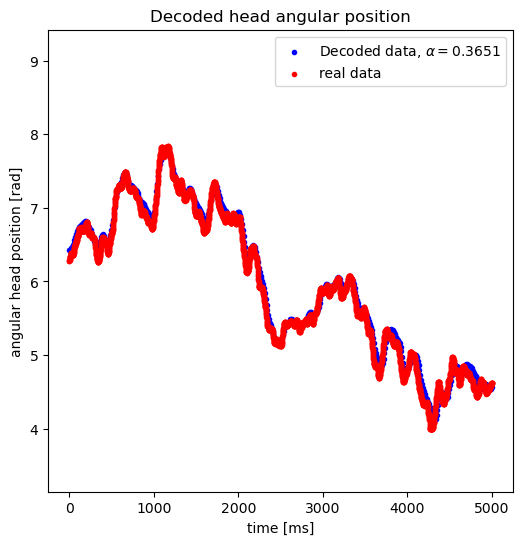

In [102]:

alpha_value = best_alpha #min_mse_alpha #0.196 * (1/dt_position) * (abs(mu_X) + 1)
# Format alpha to 4 decimal places
formatted_alpha = f"{alpha_value:.4f}"

dec_pos_overlbins_alpha_compxy, norm_rex_vector_alpha, spike_count_alpha, pop_vec= resultant_vector_overlbins_alpha(spike_matrix_01,neuro_pref_dir_vector,decoding_time_interval_otb_alpha,time_overlapping_otb_alpha,alpha_value)

dec_pos_overlbins_alpha = np.arctan2(dec_pos_overlbins_alpha_compxy[:,1], dec_pos_overlbins_alpha_compxy[:,0]) 
dec_pos_overlbins_alpha_02pi = dec_pos_overlbins_alpha + np.pi #so now the angles range from 0 to 2\pi

num_bins_to_exclude_otb_alpha = decoding_time_interval_otb_alpha // time_overlapping_otb_alpha

T_vec_intervals_otb_alpha =  np.linspace(0, T, num=(T // max(time_overlapping_otb_alpha, dt_position)) + 1 - num_bins_to_exclude_otb_alpha)
print(T_vec_intervals_otb_alpha.shape)
print(dec_pos_overlbins_alpha_compxy.shape)

fig, ax = plt.subplots(figsize=(6,6)) #plt.subplots(figsize=(7,10))
ax.scatter(T_vec_intervals_otb_alpha, dec_pos_overlbins_alpha_02pi, color='blue', marker='.', label=f'Decoded data, $\\alpha = {formatted_alpha}$')
ax.scatter(T_vec, (theta_HD+np.pi), color='red', marker='.', label='real data')

ax.scatter(T_vec_intervals_otb_alpha, dec_pos_overlbins_alpha_02pi + 2 * np.pi, color='blue', marker='.')
ax.scatter(T_vec, (theta_HD+ 3 * np.pi), color='red', marker='.')
#ax.invert_yaxis() # Invert y-axis to match matrix indexing
#ax.set_yticks(neuron_ticks)
#ax.set_yticklabels(neuron_ticks_label)
#ax.set_xticks(ticks_time_points)
#ax.set_xticklabels(ticks_time_points_label)
# Limit y-axis to only show values from pi to 3pi
ax.set_ylim([bottom_limit, up_limit])
ax.legend()
ax.set_ylabel('angular head position [rad]')
ax.set_xlabel('time [ms]')
ax.set_title('Decoded head angular position')


(496,)
(496, 1)


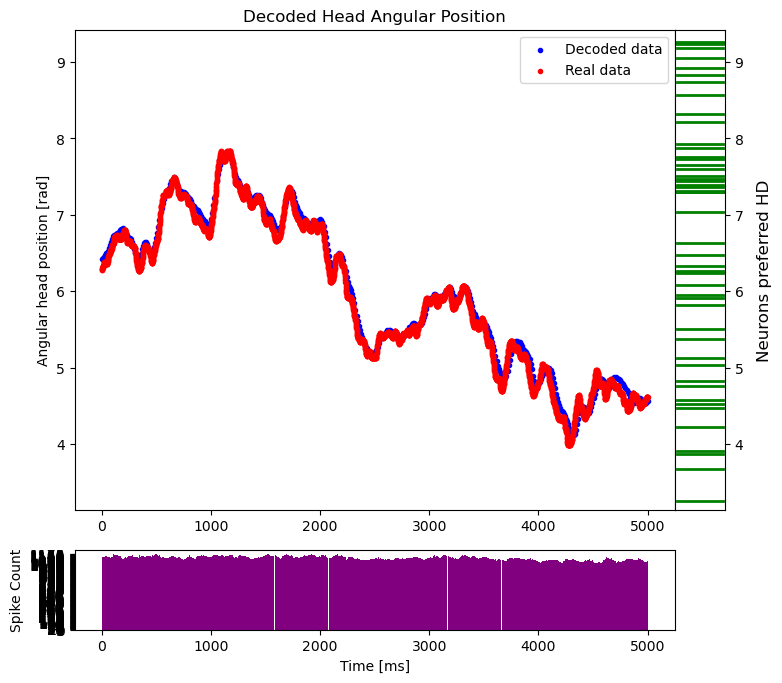

In [103]:
print(T_vec_intervals_otb_alpha.shape)
print(spike_count_alpha.shape)

# Create Main Figure and Axes
fig = plt.figure(figsize=(10, 8))

# Main Graph
ax_main = fig.add_axes([0.1, 0.2, 0.6, 0.6])  # [left, bottom, width, height]
ax_main.scatter(T_vec_intervals_otb_alpha, dec_pos_overlbins_alpha_02pi, color='blue', marker='.', label='Decoded data')
ax_main.scatter(T_vec, (theta_HD + np.pi), color='red', marker='.', label='Real data')
ax_main.scatter(T_vec_intervals_otb_alpha, dec_pos_overlbins_alpha_02pi + 2 * np.pi, color='blue', marker='.')
ax_main.scatter(T_vec, (theta_HD + 3 * np.pi), color='red', marker='.')
ax_main.set_ylim([bottom_limit, up_limit])
ax_main.set_ylabel('Angular head position [rad]')
#ax_main.set_xlabel('Time [ms]')
ax_main.legend()
ax_main.set_title('Decoded Head Angular Position')

# Right-Side Graph for Neuron Preferred Directions
ax_right = fig.add_axes([0.70, 0.2, 0.05, 0.6])  # Narrow vertical plot
# Shift for alignment
y_positions_1 = neuro_pref_dir_vector + np.pi
y_positions_2 = neuro_pref_dir_vector + 3 * np.pi

# Plot the first set (neuro_pref_dir_vector + np.pi)
for y in y_positions_1:
    ax_right.plot([0, 1], [y, y], color='green', linewidth=2)  # Line of length 1

# Plot the second set (neuro_pref_dir_vector + 3*np.pi)
for y in y_positions_2:
    ax_right.plot([0, 1], [y, y], color='green', linewidth=2)  # Line of length 1

ax_right.set_ylim(ax_main.get_ylim())
ax_right.set_xticks([])  # Hide x-axis ticks
# Show y-axis ticks on the right side
ax_right.tick_params(axis='y', left=False, right=True, labelleft=False, labelright=True)
#ax_right.set_title('Neuron Directions', rotation='vertical', loc='center', pad=30)

# Add vertical title to the right side
fig.text(
    0.79,  # x-coordinate (right side of the plot)
    0.5,  # y-coordinate (middle of the plot)
    'Neurons preferred HD',  # Title text
    ha='center',  # Center the text horizontally
    va='center',  # Center the text vertically
    rotation=90,  # Make the text vertical
    fontsize=12  # Font size
)

# Bottom Graph for Spike Count
ax_bottom = fig.add_axes([0.1, 0.05, 0.6, 0.1])  # Short horizontal plot
ax_bottom.bar(T_vec_intervals_otb_alpha, spike_count_alpha.flatten(), width=10.0, color='purple', align='center')
ax_bottom.set_xlim(ax_main.get_xlim())
ax_bottom.set_xlabel('Time [ms]')
ax_bottom.set_ylabel('Spike Count')
# Get the max spike count for setting y-ticks
max_spike_count = np.max(spike_count_alpha)

# Set y-ticks from 0 to max_spike_count with 3 intermediate ticks
ax_bottom.set_yticks(np.arange(0, max_spike_count+1, 5))  # 5 values: 0, 2 intermediate, max

# Add a thick horizontal line at spike_count = 1
#ax_bottom.axhline(y=1, color='red', linewidth=2, linestyle='--')

plt.show()


plt.show()

RMSE  :  0.07501849145625304
RMSE over alpha  :  0.2054726317983082


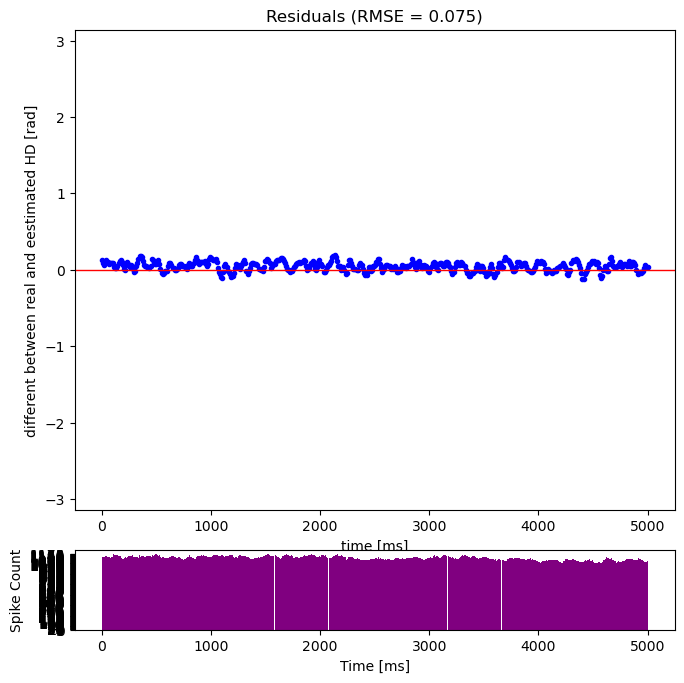

In [104]:
resultant_mean_real_positions = mean_position_vector(theta_HD, time_overlapping_otb_alpha)

res_pos_otb_alpha = -np.pi*np.ones_like(resultant_mean_real_positions[:-num_bins_to_exclude_otb_alpha].flatten()) + [
    (dec_pos_overlbins_alpha- resultant_mean_real_positions[:-num_bins_to_exclude_otb_alpha].flatten() 
     + np.pi*np.ones_like(resultant_mean_real_positions[:-num_bins_to_exclude_otb_alpha].flatten())) % (2*np.pi)]


#sum Root Squared of residuals/distances components 
sum_res_RS_otb_alpha_x = np.sqrt(np.sum((np.cos(res_pos_otb_alpha))**2)/(res_pos_otb_alpha.size))
sum_res_RS_otb_alpha_y = np.sqrt(np.sum((np.sin(res_pos_otb_alpha))**2)/(res_pos_otb_alpha.size))


#Squared root of Sum Residuals Squared (SRSS)
RMSE_otb_alpha = np.arctan2(sum_res_RS_otb_alpha_y, sum_res_RS_otb_alpha_x)

print('RMSE  : ', RMSE_otb_alpha)
print('RMSE over alpha  : ', RMSE_otb_alpha / alpha_value)


#plotting residuals

# Create Main Figure and Axes
fig = plt.figure(figsize=(10, 8))

# Main Graph
ax_main = fig.add_axes([0.1, 0.2, 0.6, 0.6])
ax_main.scatter(T_vec_intervals_otb_alpha, res_pos_otb_alpha, color='blue', marker='.', label='decoded data')
ax_main.axhline(y=0, color='red', linestyle='-', linewidth=1)
ax_main.set_ylim(-np.pi, np.pi)
ax_main.set_ylabel('different between real and eestimated HD [rad]')
ax_main.set_xlabel('time [ms]')
ax_main.set_title(f'Residuals (RMSE = {RMSE_otb_alpha:.3f})')
# Bottom Graph for Spike Count
ax_bottom = fig.add_axes([0.1, 0.05, 0.6, 0.1])  # Short horizontal plot
ax_bottom.bar(T_vec_intervals_otb_alpha, spike_count_alpha.flatten(), width=10.0, color='purple', align='center')
ax_bottom.set_xlim(ax_main.get_xlim())
ax_bottom.set_xlabel('Time [ms]')
ax_bottom.set_ylabel('Spike Count')
# Get the max spike count for setting y-ticks
max_spike_count = np.max(spike_count_alpha)

# Set y-ticks from 0 to max_spike_count with 3 intermediate ticks
ax_bottom.set_yticks(np.arange(0, max_spike_count+1, 5))  # 5 values: 0, 2 intermediate, max

# Add a thick horizontal line at spike_count = 1
#ax_bottom.axhline(y=1, color='red', linewidth=2, linestyle='--')
plt.show()



DENSITY - GAUSSIAN KERNEL

In [194]:
#i define the density as a function of the position along the circle and 
#it can be seen as a probability density of finding all neurons in that portion of space 




ker_G = np.zeros((N_neurons, len(resultant_mean_real_positions)))

sigma_kerG = 1
prefactor = 1/(np.sqrt(2*np.pi)*sigma_kerG)
norm_factor =1/(( 1/N_neurons) * (1/(np.sqrt(2*np.pi)*sigma_kerG))**N_neurons)
for i in range(N_neurons):
#defined kernel - gaussian function
    dist = -np.pi + ((resultant_mean_real_positions - neuro_pref_dir_vector[i] + np.pi) % (2*np.pi))
    ker_G[i,:] = prefactor * np.exp(-(dist**2/ (2* sigma_kerG**2 )) )

#define the density function
density_fun = norm_factor*np.prod(ker_G, axis=0)





<Figure size 640x480 with 0 Axes>

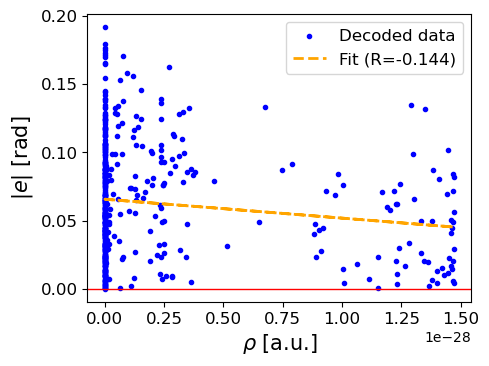

Correlation coefficient (R): -0.144


In [195]:
fig = plt.figure(figsize=(6.4, 4.8))



# Scatter data
x = density_fun[:-num_bins_to_exclude_otb_alpha]
y = abs(res_pos_otb_alpha.flatten())

# the points thatdominates the correlation are the ones close to higher densities
# i considered then points up to two orders of magnitude from the maximum density (order of 10**22)
non_zero_indices = x >  0 #10**20
x_filtered = x[non_zero_indices]
y_filtered = y[non_zero_indices]

# Perform linear regression on the filtered data
slope, intercept, r_value, p_value, std_err = linregress(x_filtered, y_filtered)

# Generate the regression line based on the filtered x values
regression_line = slope * x_filtered + intercept

# Plot
fig = plt.figure(figsize=(6.4, 4.8))

# Main Graph
ax_main = fig.add_axes([0.1, 0.2, 0.6, 0.6])
ax_main.scatter(x, y, color='blue', marker='.', label='Decoded data')
ax_main.plot(x_filtered, regression_line, color='orange', linestyle='--', linewidth=2, label=f'Fit (R={r_value:.3f})')
ax_main.axhline(y=0, color='red', linestyle='-', linewidth=1)
ax_main.set_ylabel(r'$|e|$ [rad]', fontsize=15)
ax_main.set_xlabel(r'$\rho$ [a.u.]', fontsize = 15)
ax_main.tick_params(axis='x', labelsize=12)  # x-axis tick labels
ax_main.tick_params(axis='y', labelsize=12)
ax_main.legend(fontsize = 12)

plt.show()

# Print results

print(f"Correlation coefficient (R): {r_value:.3f}")